In [1]:
import string
import random
import itertools
from itertools import cycle, chain

# Math
import numpy as np
import pandas as pd

# Bio
from Bio import motifs, SeqIO
from Bio.Align import Applications
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# custom
from unidip import UniDip
from util import *

import matplotlib.pyplot as plt
plt.style.use("seaborn")

In [145]:
motif = "|____________|"
idxs, strs = gen_mut_strs(motif, 1, 10, 150, min_offset=30, max_offset=100)
# trim(strs, len(motif))
strs

('TGGTGGGCCACAGATAGAGTTGATCACTTCCCCTTATACAAGCGCTCCTAGCTACAAAAATATCGTGTTTCT|____________|AGACCGACAAGGCTGTCGGGCCGGACTCATAGGCCTCACTCAGGGGCAACGGTGGTCCGTAGTG',
 'TCACCTGACGTCCGGGTGGTAAACCTTTCTCCCTA|____________|TAGGATCTCTAAGAGTTTTAGCAGTAGTAACTGGCTGAGCCGGCGTTACAACAATCACACCCACCATCACGCATGTTCTTCACATAGTAGTTGCGATAATA',
 'ACCGTTGCTGGAACTTATGAAGAGCCTTTCCGCATCGCCACATCCGGGCTCCACAAT|____________|TAATCCGACTATCGGACGCCGACTAGGAAGCGTTAAGTGAGAACTCGATACGTACGGACGGGATTTGTTCTCAATGTTC',
 'CCTAGGACCGACTTTAAGAATAAGTGCCTAGTAGCTCGA|____________|TCGGTTGTGGGAGCAAGTTCCCCACACTGATGATCTCTATGATAACTATGCCCACCGCATCGCTCGCTGCAGAAACGTCAGAACTGAACGGTTAACG',
 'GGCCAGTCGAACTGGGTCACGGTGACTTGGTACGAACTCCCTCAGGAATGCGCATCCTCGGATGAGGA|____________|GCCCAGTCAATCGGATAAGCTGTGAAACCCTTGAAGGGGTGGGTTGATCGACTGGCAACGACTTTTCC',
 'CTTATCGAGTCCCGGCAATTTAGTTGCCGGAGCTCGTCTAAGCTATTTGAAGCCGAAACAAGTCTGCCGGACAAATCCTAAGCCAACG|____________|TGGACACATACCCTGGGCTTATATGAAGAGCGAGCAGCATCGCGACTC',
 'GCGTTGGGAGAGGTTGGATCAACGGCTTACGGATATATTGCATTTACTGATTAGTTACAGATTGACAT

In [3]:
def get_trim_diffs(res, alignedA, alignedT, labs):
    trimStartSites, diffs = [], []
    for cl in res:
        idxs = alignedT.iloc[cl[0]:cl[1],:]["index"]
        trimStartSites.append([])
        for seq in alignedA:
            strt = idxs.iloc[0] if len(idxs) > 0 else 0
            trimStartSites[-1].append(strt-str(seq.seq).count('-', 0, strt))
    
    for tss in trimStartSites:
        diffs.append(list(map(lambda a, b: np.sqrt((a[0] - b) ** 2), labs, tss)))
    
    return [sum(d) / len(d) for d in diffs], diffs

def get_coverage(res, alignedA, alignedT, labs, motif_len):
    trimStartSites, trimEndSites = [], []
    for cl in res:
        idxs = alignedT.iloc[cl[0]:cl[1],:]["index"]
        trimStartSites.append([])
        trimEndSites.append([])
        for seq in alignedA:
            strt = idxs.iloc[0] if len(idxs) > 0 else 0
            end = idxs.iloc[-1] if len(idxs) > 0 else len(seq)
            trimStartSites[-1].append(strt-str(seq.seq).count('-', 0, strt))
            trimEndSites[-1].append(end-str(seq.seq).count('-', 0, end))
    
    diffs = []
    for pss, pes in zip(trimStartSites, trimEndSites): # for each cluster
        captured = list(map(lambda ms, ps, pe: (ps < ms[0] < pe or ps < ms[0]+motif_len < pe), labs, pss, pes))
        diffs.append(captured)
        
    capture_ratios = [sum(d) / len(d) for d in diffs]
    seq_ratios = [(r[1] - r[0]) / alignedT[0].shape[0] for r in res]
    return [cr / lr for cr, lr in zip(capture_ratios, seq_ratios)], capture_ratios

In [4]:
def run_trials(ntrials, **kwargs):
    errors = []
    muscle_exe = r"./muscle3.8.31_i86linux64"
    in_file = r"./generated.fasta"
    out_file = r"./generatedaligned.fasta"
    muscle_cline = Applications.MuscleCommandline(muscle_exe, input=in_file, out=out_file)
    for i in range(ntrials):
        # gen strs
        labs, strings = gen_mut_strs(**kwargs)
        seqs = [SeqRecord(Seq(s), id=f"Seq{i}", description="Generated Sequence") for i, s in zip(range(len(strings)), strings)]
        SeqIO.write(seqs, in_file, 'fasta')

        # alignment
        muscle_cline()
        alignedSeqs = list(SeqIO.parse(out_file, "fasta"))

        # run UniDip
        cts = pd.DataFrame([[let for let in str(s.seq)] for s in alignedSeqs]).apply(pd.value_counts).fillna(0).T.to_dict()
        nent = pd.DataFrame(cts).apply(lambda x: 2-shannonEntropy(x), 1) 
        nent_trimmed = nent[nent > 0.01].reset_index()
        res1 = UniDip(np.array(nent_trimmed[0]), alpha=.05, is_hist=True, merge_distance=10, debug=False).run()
        if len(res1) == 1:
            res1 = [UniDip(np.array(nent_trimmed[0]), alpha=.05, is_hist=True, merge_distance=10, debug=False)._get_full_interval(res1[0])]


        # get diffs
        p = get_coverage(res1, alignedSeqs, nent_trimmed, labs, len(kwargs.get('motif')) if kwargs.get('motif') else 15)[0]
        errors.append(max(p))
    return errors


def test_parameters(ntrials=100, **kwargs):
    """
        default parameters:
            insert_num=1,
            Nstrs=50,
            str_len=100,
            min_offset = ((str_len//insert_num)//2) if min_offset == None else min_offset
            max_offset = min_offset if max_offset == None else max_offset
            min_gap = str_len//insert_num if min_gap == None else min_gap
            max_gap = min_gap if max_gap == None else max_gap 
            mutate_num = 0 if mutate_num == None else mutate_num
    """
    dat = {'trials': [], "idx": []}
    
    for k, v in kwargs.items():
        assert type(v) == list, "arguments must be lists"
        
    vals = list(itertools.product(*kwargs.values()))
    keys = list(itertools.repeat(list(kwargs.keys()), len(vals)))
    for idx, dct in zip(range(len(vals)), [dict(map(list, zip(x, y))) for x, y in zip(keys, vals)]):   
            print(f"Testing {list(dct.keys())} with perameters {list(dct.values())}")
            dat['trials'].append(run_trials(ntrials, **dct))
            dat['idx'].append({f'Trial{idx}': dct})
        
    print("done")
    return dat

In [ ]:
dat = test_parameters(motif=["ACTTGCTAGCATCGAT"], Nstrs=[50], str_len=[500], min_offset=[0], max_offset=[470])

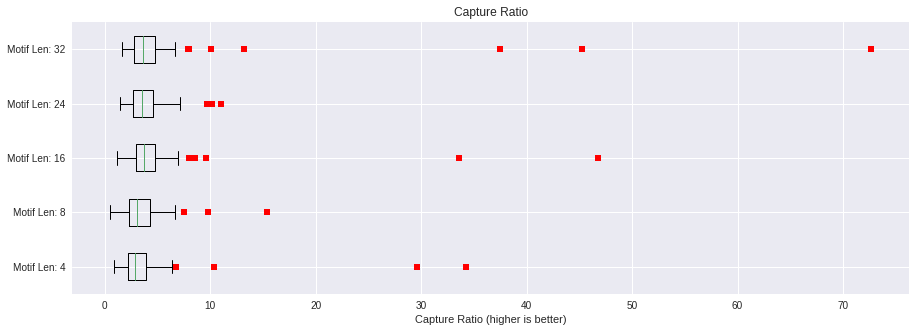

In [22]:
trials = pd.DataFrame(dat["trials"])

plt.figure(figsize=[15, 5])
plt.boxplot(trials,  0, 'rs', 0, labels=[f"Motif Len: {i}" for i in [4, 8, 16, 24, 32]])
plt.title("Capture Ratio")
plt.xlabel("Capture Ratio (higher is better)")
plt.ylabel("")

plt.show()

In [ ]:
trials.T.loc[]

In [17]:
2 - shannonEntropy([10, 1, 5, 7])

0.27993395166966817